# Accessing higher energy states with Qiskit Pulse

This notebook created figure 2a and 2d in our paper

# Contents

[Importing](#importing)  
[Discriminating the 0, 1 and 2 states](#discrim012)  
&emsp; [Computing the 1->2 Frequency](#freq12)  
&emsp; [1->2 Rabi Experiment](#rabi12)  
&emsp; [Build the 0, 1, 2 discriminator](#builddiscrim012)  


## Importing <a id="importing"></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit.tools.monitor import job_monitor

In [2]:
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
provider = IBMQ.load_account()
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
backend = provider.get_backend('ibmq_jakarta')

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024*2

Qubit 0 has an estimated frequency of 5.236540760010473 GHz.
Default anharmonicity is -0.339883615358574 GHz.


In [3]:
default_qubit_freq+default_anharmonicity*GHz

4896658986.504366

We define some additional helper functions.

In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

## Plot the pi-pulse's shape

Drag(duration=160, amp=(0.20021503099113458+0j), sigma=40, beta=-0.9856743268802413, name='Xp_d0')
Drag(duration=160, amp=(0.1002059320542878+0.0008979109589330327j), sigma=40, beta=-1.0472448858945778, name='X90p_d0')


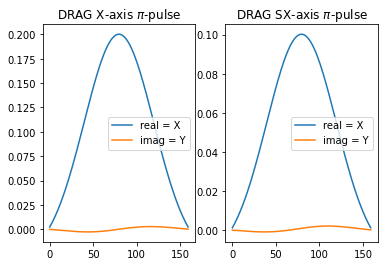

In [5]:
x180 = backend.defaults().instruction_schedule_map.get('x',qubit).instructions[0][1].pulse
pulse180 = x180.get_waveform().samples
print(x180)
plt.subplot(1,2,1)
plt.plot(np.real(pulse180), label="real = X")
plt.plot(np.imag(pulse180), label="imag = Y")
plt.legend(loc=0)
plt.title("DRAG X-axis $\pi$-pulse")
# plt.show()
x90 = backend.defaults().instruction_schedule_map.get('sx',qubit).instructions[0][1].pulse
pulse90 = x90.get_waveform().samples
print(x90)
plt.subplot(1,2,2)

plt.plot(np.real(pulse90), label="real = X")
plt.plot(np.imag(pulse90), label="imag = Y")
plt.legend(loc=0)
plt.title("DRAG SX-axis $\pi$-pulse")
plt.show()

Next we include some default parameters for drive pulses. 

In [8]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

## Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

The process for building the higher state discriminator:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.


### Computing the 1->2 frequency <a id="freq12"></a>

In [9]:
# smaller range sweep
num_freqs = 150
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [10]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [11]:
spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(1+qubit, 1+qubit)

qc_spect.x(qubit)
qc_spect.append(spect_gate, [qubit])
qc_spect.measure(qubit, qubit)
qc_spect.add_calibration(spect_gate, (qubit,), freq12_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

In [12]:
excited_freq_sweep_job = backend.run(exp_spect_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=NUM_SHOTS*4)

In [13]:
excited_freq_sweep_job.job_id()

'6293a72b16cdc45c12f259b8'

In [19]:
629231ad4bb975606cefad3f # May 29

In [14]:
job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [4]:
excited_freq_sweep_job = backend.retrieve_job('6293a72b16cdc45c12f259b8')

In [11]:
# Get the refined data (average)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [12]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [13]:
# do fit in Hz
(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4896659172.673435, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

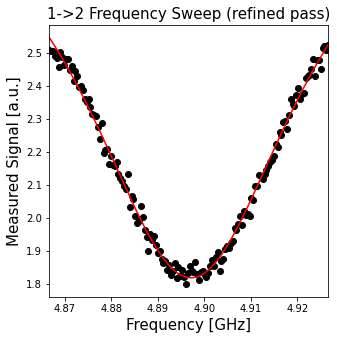

In [36]:
# Note: we are only plotting the real part of the signal
plt.figure(figsize=(5, 5))

plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
# plt.show()
plt.savefig('sweep_freq12.svg',dpi=240)

In [19]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.8971702 GHz.


In [20]:
qubit_12_freq # May 29

4897035127.906342

### 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency.

In [24]:
# experimental configuration
num_rabi_points = 200 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = -1
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

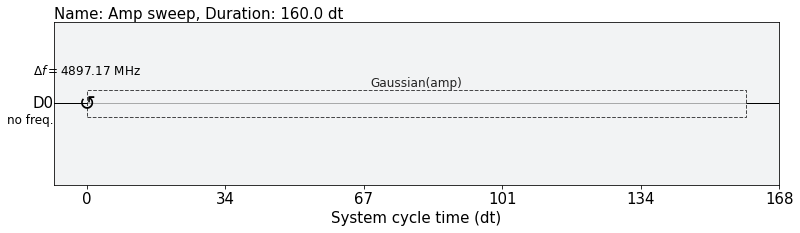

In [22]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
rabi_sched.draw()

Avg. T1:
130.36 us
Avg. T2:
39.07 us

In [23]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(qubit+1, qubit+1)

qc_rabi.x(qubit)
qc_rabi.append(rabi_gate, [qubit])
qc_rabi.measure(qubit, qubit)
qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]
    

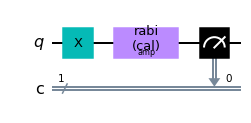

In [24]:
qc_rabi.draw()    

In [25]:
rabi_12_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=1024*8)

In [26]:
job_monitor(rabi_12_job)

Job Status: job has successfully run


In [27]:
rabi_12_job.job_id()
# 6292389d1ea57f4090ebcf37 4096 shots May 29 

'6293a985bc0d02c50bdbe873'

In [20]:
rabi_12_job=backend.retrieve_job('6293a985bc0d02c50bdbe873')

In [21]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

In [22]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

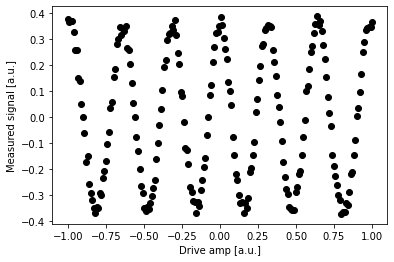

In [25]:
rabi_results = rabi_12_job.result(timeout=120)
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

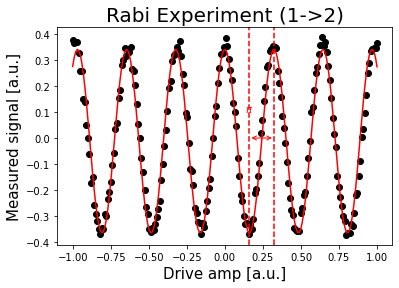

In [26]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit
# Note: Only real part of data is plotted
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.25, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')
drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.savefig('Rabi_12_shift_freq.svg',dpi=240)

We plot and fit our data as before.

In [34]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.8970351 GHz.
Pi Amplitude (1->2) = 0.16148658917530523


### Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

Finally, we build our discriminator for the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states. 

As a review, our three circuits are (again, recalling that our system starts in the $|0\rangle$ state): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply $0\rightarrow1$ $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).
3.  Apply $0\rightarrow1$ $\pi$ pulse, then $1\rightarrow2$ $\pi$ pulse, then measure (obtain $|2\rangle$ centroid).

In [36]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [ ]:
qc_one = QuantumCircuit(qubit+1, qubit+1)
qc.rz(-4)
qc_one.rx(-3)
qc_one.measure(qubit, qubit)
rx12(-a2)
rx01(-a3+2*t12m)

In [43]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(qubit+1, qubit+1)
qc_ground.measure(qubit, qubit)

# 1 state
qc_one = QuantumCircuit(qubit+1, qubit+1)
qc_one.x(qubit)
qc_one.measure(qubit, qubit)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(qubit+1, qubit+1)
qc_x12.x(qubit)
qc_x12.append(x12_gate, [qubit])
qc_x12.measure(qubit, qubit)
qc_x12.add_calibration(x12_gate, (qubit,), x12_sched, [])

We construct the program and plot the centroids in the IQ plane.

In [49]:
# Assemble the schedules into a program
IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=NUM_SHOTS*8)
job_monitor(IQ_012_job)
IQ_012_job.job_id()

Job Status: job has successfully run


'62923f4b4ad655b08a9e42e0'

In [27]:
IQ_012_job = backend.retrieve_job('62923f4b4ad655b08a9e42e0')

In [28]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [29]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [58]:
-default_qubit_freq+qubit_12_freq

-339507660.1256676

In [59]:
pi_amp_12, qubit_12_freq

(0.16148658919194517, 4897035127.906342)

# Below is the IBM default qutrit discrimintor for jakarta qubit 0

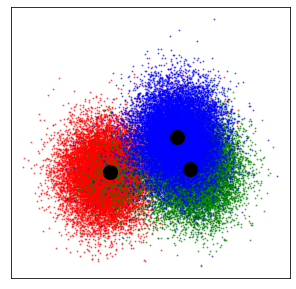

In [37]:
# zero data plotted in blue
plt.figure(figsize=(5, 5))

plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=1, cmap='viridis', c='red', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=1, cmap='viridis', c='green', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data), np.imag(two_data), 
                s=1, cmap='viridis', c='blue', alpha=0.5, label=r'$|2\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_two), np.imag(mean_two), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.xticks([])
plt.yticks([])
plt.savefig('discrim_default.svg',dpi=240)

# Our qutrit discriminator is far better than this! 
See the measurement finetune notebooks which we sweep the silhouette score as a function of measurement's amplitude and duration 